# Feature learning on metric point clouds for segmentation and classification
Even though 3D sensing of the environment with low-cost sensors is commonplace, very few DL approaches actively exploit the inherent benefits of having a metric spatial imaging of the object you try to classify. Intuitively - DNNs used for object classification using 2D data would have to spend capacity learning slightly different poses of objects where a point cloud based network could more efficiently encode the features by being pose invariant.  

![Pointnet teaser](http://stanford.edu/~rqi/pointnet/images/teaser.jpg)

One such network is [PointNet++](https://stanford.edu/~rqi/pointnet2/) The general idea of PointNet++ is simple. We first partition the set of points into overlapping local regions by the distance metric of the underlying space. Similar to CNNs, we extract local features capturing fine geometric structures from small neighborhoods; such local features are further grouped into larger units and processed to produce higher level features. This process is repeated until we obtain the features of the whole point set.

![Overall structure of PointNet. Note the reuse for early layers for different end tasks](https://stanford.edu/~rqi/pointnet2/images/pnpp.jpg)  

As is quite obvious from the illustrated network structure, segmentation is very similar to an encode-decode bottleneck, and classification by using similar encoding and a fully connected stack. 

In this network the direct analog to a convolutional layer is the PointNet. This is quite simply a stack containing an input align network that feeds point data into a stack of MLPs that are max-pooled and fed into a feature aligner. The output from this feature alignment is (hopefully!) a canonical feature representation of the input. This architecture can be trained with classical back propagation.

For further reference, consult the paper or [slide deck](http://stanford.edu/~rqi/pointnet/docs/cvpr17_pointnet_slides.pdf) from Qi et al from CVPR 2017. These slides do a very good job of explaining the network as well as demonstrating that the PointNet learns non-trivial features of the point clouds.  

One interesting detail with PointNet is the relatively low cost for inference compared to extending a regular convnet to an extra dimension, since the representation is fairly efficient in the number of weights (which grows geometrically with dimension) 

The experiments in this lab will be on pre-trained models due to the computational cost of training.

##Exercise

## Old stuff
- **Classification pipeline**: Run through a couple of examples from the ModelNet database and observe performance. Try different hierarchical groupings, single scale and multi scale. Can you observe any improvement? 
- **Parts segmentation pipeline**: In principle there are two strategies for encoding 
- **Preprocess and classify own captured point cloud data**: Consider 
- **For extra credit: See how much you can transform the point clouds before classifier breaks down**
- **For extra credit: Experiment with scripts for training classification and segmentation**

The original code has been adapted to a notebook format, and this can cause some confusion. When changing parameters some cells containing only defs may need to be rerun.  

In [1]:
import argparse
import math
from datetime import datetime
import h5py
import numpy as np
import tensorflow as tf
import socket
import importlib
import os
import sys
from pyntcloud import PyntCloud
ROOT_DIR = os.path.dirname(os.path.abspath('../../pointnet2/model'))
BASE_DIR = os.path.dirname(ROOT_DIR)
#print(ROOT_DIR) #should not be empty, assuming that installation of lab files are unchanged.  
TF_OPS_DIR = os.path.join(ROOT_DIR, 'tf_ops')
sampling_module = tf.load_op_library(os.path.join(TF_OPS_DIR, 'sampling/tf_sampling_so.so'))
grouping_module = tf.load_op_library(os.path.join(TF_OPS_DIR, 'grouping/tf_grouping_so.so'))
interpolation_module = tf.load_op_library(os.path.join(TF_OPS_DIR, '3d_interpolation/tf_interpolate_so.so'))


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [2]:
#Pointcloud vizualizer test
# Needs pythreejs extension and jupyterlab-manager to jupyter
#sudo pip install pythreejs
#sudo jupyter nbextension install --py --symlink --sys-prefix pythreejs
#sudo jupyter nbextension enable --py --sys-prefix pythreejs
#sudo jupyter labextension install @jupyter-widgets/jupyterlab-manager
#See https://github.com/jupyter-widgets/pythreejs/issues/206

anky = PyntCloud.from_file("/home/developer/ankylosaurus_mesh.ply")
anky
anky.plot(mesh=True,backend="threejs")


In [3]:
anky_cloud = anky.get_sample("mesh_random", n=100000, rgb=True, normals=True, as_PyntCloud=True)

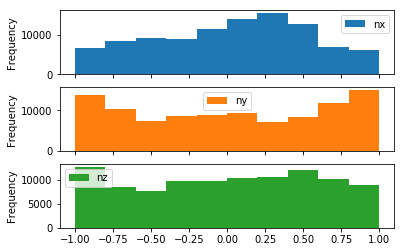

In [4]:
anky_cloud.points[["nx", "ny", "nz"]].plot(kind="hist", subplots=True);

In [5]:
scene = anky_cloud.plot(return_scene=True)
display(scene)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.015693752095103264, 2.4170607328414917, 7.…

Preview(child=Scene(children=(Points(geometry=BufferGeometry(attributes={'position': <BufferAttribute shape=(1…

In [6]:
anky_cloud.plot(use_as_color="x", cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.015693752095103264, 2.4170607328414917, 7.…

In [7]:
sys.path.append(ROOT_DIR) # provider
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
import provider
import tf_util
import pc_util
sys.path.append(os.path.join(ROOT_DIR, 'scannet'))
import scannet_dataset
sys.path.append(os.path.join(ROOT_DIR,'models'))

In [15]:
#parser = argparse.ArgumentParser()
#parser.add_argument('--gpu', type=int, default=0,
#                    help='GPU to use [default: GPU 0]')
#parser.add_argument('--model', default='model',
#                    help='Model name [default: model]')
#parser.add_argument('--log_dir', default='log', help='Log dir [default: log]')
#parser.add_argument('--num_point', type=int, default=8192,
#                    help='Point Number [default: 8192]')
#parser.add_argument('--max_epoch', type=int, default=201,
#                    help='Epoch to run [default: 201]')
#parser.add_argument('--batch_size', type=int, default=32,
#                    help='Batch Size during training [default: 32]')
#parser.add_argument('--learning_rate', type=float, default=0.001,
#                    help='Initial learning rate [default: 0.001]')
#parser.add_argument('--momentum', type=float, default=0.9,
#                    help='Initial learning rate [default: 0.9]')
#parser.add_argument('--optimizer', default='adam',
#                    help='adam or momentum [default: adam]')
#parser.add_argument('--decay_step', type=int, default=200000,
#                    help='Decay step for lr decay [default: 200000]')
#parser.add_argument('--decay_rate', type=float, default=0.7,
#                    help='Decay rate for lr decay [default: 0.7]')


SEG_BATCH_SIZE = 16 
SEG_NUM_POINT = 8192
SEG_LOG_DIR = os.path.join(BASE_DIR,'semantic_seg/log/') #Where to point tensorflow
SEG_CKPT_NAME = 'model.ckpt' #Change to avoid overwriting if training 
SEG_MODEL_PATH = os.path.join(SEG_LOG_DIR,SEG_CKPT_NAME)
SEG_MODELNAME = 'pointnet2_sem_seg'
SEG_MODEL_FILE = os.path.join(ROOT_DIR, 'models', SEG_MODELNAME+'.py')
SEG_MODEL = importlib.import_module(SEG_MODELNAME) # import network module - look in models folder for others
SEG_VOTE_NUM = 12
EPOCH_CNT = 0

#SEG_MODEL_FILE = os.path.join(ROOT_DIR, 'models', SEG_MODELNAME+'.py')
if not os.path.exists(SEG_LOG_DIR): mkdir_p(SEG_LOG_DIR)
os.system('cp %s %s' % (SEG_MODEL_FILE, SEG_LOG_DIR)) # bkp of model def
#os.system('cp train.py %s' % (SEG_LOG_DIR)) # bkp of train procedure
SEG_NUM_CLASSES = 50

SEG_MAX_EPOCH = 201  #FLAGS.max_epoch
SEG_BASE_LEARNING_RATE = 0.001 #FLAGS.learning_rate
GPU_INDEX = 1#FLAGS.gpu
SEG_MOMENTUM = 0.9 #FLAGS.momentum
SEG_OPTIMIZER = 'adam' #FLAGS.optimizer
SEG_DECAY_STEP = 200000 #FLAGS.decay_step
SEG_DECAY_RATE = 0.7 #FLAGS.decay_rate


In [16]:
#MODEL = importlib.import_module(NETMODEL)  # import network module
#MODEL_FILE = os.path.join(BASE_DIR, NETMODEL+'.py')
#if not os.path.exists(SEG_LOG_DIR):
#    mkdir_p(SEG_LOG_DIR)
#os.system('cp %s %s' % (MODEL_FILE, SEG_LOG_DIR))  # bkp of model def
#os.system('cp train.py %s' % (LOG_DIR))  # bkp of train procedure
LOG_FOUT = open(os.path.join(SEG_LOG_DIR, 'log_train.txt'), 'w')
#LOG_FOUT.write(str(FLAGS)+'\n') 

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(SEG_DECAY_STEP)
BN_DECAY_CLIP = 0.99

HOSTNAME = socket.gethostname()

SEG_NUM_CLASSES = 21

In [17]:
#Loading takes some time. Be patient
print('Loading data...')
DATA_PATH = os.path.join(ROOT_DIR, 'data', 'scannet_data_pointnet2')
SEG_TRAIN_DATASET = scannet_dataset.ScannetDataset(
    root=DATA_PATH, npoints=SEG_NUM_POINT, split='train')
SEG_TEST_DATASET = scannet_dataset.ScannetDataset(
    root=DATA_PATH, npoints=SEG_NUM_POINT, split='test')
SEG_TEST_DATASET_WHOLE_SCENE = scannet_dataset.ScannetDatasetWholeScene(
    root=DATA_PATH, npoints=SEG_NUM_POINT, split='test')
print('Done')

Loading data...
Done


In [18]:
def log_string(out_str):
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)
    
def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
        SEG_BASE_LEARNING_RATE,  # Base learning rate.
        batch * SEG_BATCH_SIZE,  # Current index into the dataset.
        SEG_DECAY_STEP,          # Decay step.
        SEG_DECAY_RATE,          # Decay rate.
        staircase=True)
    # CLIP THE LEARNING RATE!
    learing_rate = tf.maximum(learning_rate, 0.00001)
    return learning_rate

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
        BN_INIT_DECAY,
        batch*SEG_BATCH_SIZE,
        BN_DECAY_DECAY_STEP,
        BN_DECAY_DECAY_RATE,
        staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

In [23]:
def train():
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl, smpws_pl = SEG_MODEL.placeholder_inputs(
                SEG_BATCH_SIZE, SEG_NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            # Note the global_step=batch parameter to minimize.
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            print("--- Get model and loss")
            # Get model and loss
            pred, end_points = SEG_MODEL.get_model(
                pointclouds_pl, is_training_pl, SEG_NUM_CLASSES, bn_decay=bn_decay)
            loss = SEG_MODEL.get_loss(pred, labels_pl, smpws_pl)#, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 2), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(
                tf.cast(correct, tf.float32)) / float(SEG_BATCH_SIZE*SEG_NUM_POINT)
            tf.summary.scalar('accuracy', accuracy)

            print("--- Get training operator")
            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if SEG_OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(
                    learning_rate, momentum=SEG_MOMENTUM)
            elif SEG_OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(
            os.path.join(SEG_LOG_DIR, 'train'), sess.graph)
        test_writer = tf.summary.FileWriter(
            os.path.join(SEG_LOG_DIR, 'test'), sess.graph)

        # Init variables
        init = tf.global_variables_initializer()
        sess.run(init)
        #sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'smpws_pl': smpws_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch,
               'end_points': end_points}

        best_acc = -1
        for epoch in range(SEG_MAX_EPOCH):
            log_string('**** EPOCH %03d ****' % (epoch))
            sys.stdout.flush()
            train_one_epoch(sess, ops, train_writer)
            if epoch % 5 == 0:
                acc = eval_one_epoch(sess, ops, test_writer)
                acc = eval_whole_scene_one_epoch(sess, ops, test_writer)
            if acc > best_acc:
                best_acc = acc
                save_path = saver.save(sess, os.path.join(
                    SEG_LOG_DIR, "best_model_epoch_%03d.ckpt" % (epoch)))
                log_string("Model saved in file: %s" % save_path)

            # Save the variables to disk.
            if epoch % 10 == 0:
                save_path = saver.save(
                    sess, os.path.join(SEG_LOG_DIR, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)


def get_batch_wdp(dataset, idxs, start_idx, end_idx):
    bsize = end_idx-start_idx
    batch_data = np.zeros((bsize, SEG_NUM_POINT, 3))
    batch_label = np.zeros((bsize, SEG_NUM_POINT), dtype=np.int32)
    batch_smpw = np.zeros((bsize, SEG_NUM_POINT), dtype=np.float32)
    for i in range(bsize):
        ps, seg, smpw = dataset[idxs[i+start_idx]]
        batch_data[i, ...] = ps
        batch_label[i, :] = seg
        batch_smpw[i, :] = smpw

        dropout_ratio = np.random.random()*0.875  # 0-0.875
        drop_idx = np.where(np.random.random(
            (ps.shape[0])) <= dropout_ratio)[0]
        batch_data[i, drop_idx, :] = batch_data[i, 0, :]
        batch_label[i, drop_idx] = batch_label[i, 0]
        batch_smpw[i, drop_idx] *= 0
    return batch_data, batch_label, batch_smpw


def get_batch(dataset, idxs, start_idx, end_idx):
    bsize = end_idx-start_idx
    batch_data = np.zeros((bsize, SEG_NUM_POINT, 3))
    batch_label = np.zeros((bsize, SEG_NUM_POINT), dtype=np.int32)
    batch_smpw = np.zeros((bsize, SEG_NUM_POINT), dtype=np.float32)
    for i in range(bsize):
        ps, seg, smpw = dataset[idxs[i+start_idx]]
        batch_data[i, ...] = ps
        batch_label[i, :] = seg
        batch_smpw[i, :] = smpw
    return batch_data, batch_label, batch_smpw


def train_one_epoch(sess, ops, train_writer):
    """ ops: dict mapping from string to tf ops """
    is_training = True
    # Shuffle train samples
    train_idxs = np.arange(0, len(SEG_TRAIN_DATASET))
    np.random.shuffle(train_idxs)
    num_batches = int(len(SEG_TRAIN_DATASET)/SEG_BATCH_SIZE)

    log_string(str(datetime.now()))

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    for batch_idx in range(num_batches):
        start_idx = batch_idx * SEG_BATCH_SIZE
        end_idx = (batch_idx+1) * SEG_BATCH_SIZE
        batch_data, batch_label, batch_smpw = get_batch_wdp(
            SEG_TRAIN_DATASET, train_idxs, start_idx, end_idx)
        # Augment batched point clouds by rotation
        aug_data = provider.rotate_point_cloud_z(batch_data)
        feed_dict = {ops['pointclouds_pl']: aug_data,
                     ops['labels_pl']: batch_label,
                     ops['smpws_pl']: batch_smpw,
                     ops['is_training_pl']: is_training, }
        summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                                                         ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
        train_writer.add_summary(summary, step)
        pred_val = np.argmax(pred_val, 2)
        correct = np.sum(pred_val == batch_label)
        total_correct += correct
        total_seen += (SEG_BATCH_SIZE*SEG_NUM_POINT)
        loss_sum += loss_val
        if (batch_idx+1) % 10 == 0:
            log_string(' -- %03d / %03d --' % (batch_idx+1, num_batches))
            log_string('mean loss: %f' % (loss_sum / 10))
            log_string('accuracy: %f' % (total_correct / float(total_seen)))
            total_correct = 0
            total_seen = 0
            loss_sum = 0

# evaluate on randomly chopped scenes
def eval_one_epoch(sess, ops, test_writer):
    """ ops: dict mapping from string to tf ops """
    global EPOCH_CNT
    is_training = False
    test_idxs = np.arange(0, len(SEG_TEST_DATASET))
    num_batches = int(len(SEG_TEST_DATASET)/SEG_BATCH_SIZE)

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    total_seen_class = [0 for _ in range(SEG_NUM_CLASSES)]
    total_correct_class = [0 for _ in range(SEG_NUM_CLASSES)]

    total_correct_vox = 0
    total_seen_vox = 0
    total_seen_class_vox = [0 for _ in range(SEG_NUM_CLASSES)]
    total_correct_class_vox = [0 for _ in range(SEG_NUM_CLASSES)]

    log_string(str(datetime.now()))
    log_string('---- EPOCH %03d EVALUATION ----' % (EPOCH_CNT))

    labelweights = np.zeros(21)
    labelweights_vox = np.zeros(21)
    for batch_idx in range(num_batches):
        start_idx = batch_idx * SEG_BATCH_SIZE
        end_idx = (batch_idx+1) * SEG_BATCH_SIZE
        batch_data, batch_label, batch_smpw = get_batch(
            SEG_TEST_DATASET, test_idxs, start_idx, end_idx)

        aug_data = provider.rotate_point_cloud_z(batch_data)

        feed_dict = {ops['pointclouds_pl']: aug_data,
                     ops['labels_pl']: batch_label,
                     ops['smpws_pl']: batch_smpw,
                     ops['is_training_pl']: is_training}
        summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                                                      ops['loss'], ops['pred']], feed_dict=feed_dict)
        test_writer.add_summary(summary, step)
        pred_val = np.argmax(pred_val, 2)  # BxN
        correct = np.sum((pred_val == batch_label) & (batch_label > 0) & (
            batch_smpw > 0))  # evaluate only on 20 categories but not unknown
        total_correct += correct
        total_seen += np.sum((batch_label > 0) & (batch_smpw > 0))
        loss_sum += loss_val
        tmp, _ = np.histogram(batch_label, list(range(22)))
        labelweights += tmp
        for l in range(SEG_NUM_CLASSES):
            total_seen_class[l] += np.sum((batch_label == l)
                                          & (batch_smpw > 0))
            total_correct_class[l] += np.sum((pred_val == l)
                                             & (batch_label == l) & (batch_smpw > 0))

        for b in range(batch_label.shape[0]):
            _, uvlabel, _ = pc_util.point_cloud_label_to_surface_voxel_label_fast(aug_data[b, batch_smpw[b, :] > 0, :], np.concatenate(
                (np.expand_dims(batch_label[b, batch_smpw[b, :] > 0], 1), np.expand_dims(pred_val[b, batch_smpw[b, :] > 0], 1)), axis=1), res=0.02)
            total_correct_vox += np.sum((uvlabel[:, 0]
                                         == uvlabel[:, 1]) & (uvlabel[:, 0] > 0))
            total_seen_vox += np.sum(uvlabel[:, 0] > 0)
            tmp, _ = np.histogram(uvlabel[:, 0], list(range(22)))
            labelweights_vox += tmp
            for l in range(SEG_NUM_CLASSES):
                total_seen_class_vox[l] += np.sum(uvlabel[:, 0] == l)
                total_correct_class_vox[l] += np.sum(
                    (uvlabel[:, 0] == l) & (uvlabel[:, 1] == l))

    log_string('eval mean loss: %f' % (loss_sum / float(num_batches)))
    log_string('eval point accuracy vox: %f' %
               (total_correct_vox / float(total_seen_vox)))
    log_string('eval point avg class acc vox: %f' % (np.mean(np.array(
        total_correct_class_vox[1:])/(np.array(total_seen_class_vox[1:], dtype=np.float)+1e-6))))
    log_string('eval point accuracy: %f' % (total_correct / float(total_seen)))
    log_string('eval point avg class acc: %f' % (np.mean(np.array(
        total_correct_class[1:])/(np.array(total_seen_class[1:], dtype=np.float)+1e-6))))
    labelweights_vox = labelweights_vox[1:].astype(
        np.float32)/np.sum(labelweights_vox[1:].astype(np.float32))
    caliweights = np.array([0.388, 0.357, 0.038, 0.033, 0.017, 0.02, 0.016, 0.025, 0.002,
                            0.002, 0.002, 0.007, 0.006, 0.022, 0.004, 0.0004, 0.003, 0.002, 0.024, 0.029])
    log_string('eval point calibrated average acc: %f' % (np.average(np.array(
        total_correct_class[1:])/(np.array(total_seen_class[1:], dtype=np.float)+1e-6), weights=caliweights)))
    per_class_str = 'vox based --------'
    for l in range(1, SEG_NUM_CLASSES):
        per_class_str += 'class %d weight: %f, acc: %f; ' % (
            l, labelweights_vox[l-1], total_correct_class[l]/float(total_seen_class[l]))
    log_string(per_class_str)
    EPOCH_CNT += 1
    return total_correct/float(total_seen)

# evaluate on whole scenes to generate numbers provided in the paper
def eval_whole_scene_one_epoch(sess, ops, test_writer):
    """ ops: dict mapping from string to tf ops """
    global EPOCH_CNT
    is_training = False
    test_idxs = np.arange(0, len(SEG_TEST_DATASET_WHOLE_SCENE))
    num_batches = int(len(SEG_TEST_DATASET_WHOLE_SCENE))

    total_correct = 0
    total_seen = 0
    loss_sum = 0
    total_seen_class = [0 for _ in range(SEG_NUM_CLASSES)]
    total_correct_class = [0 for _ in range(SEG_NUM_CLASSES)]

    total_correct_vox = 0
    total_seen_vox = 0
    total_seen_class_vox = [0 for _ in range(SEG_NUM_CLASSES)]
    total_correct_class_vox = [0 for _ in range(SEG_NUM_CLASSES)]

    log_string(str(datetime.now()))
    log_string('---- EPOCH %03d EVALUATION WHOLE SCENE----' % (EPOCH_CNT))

    labelweights = np.zeros(21)
    labelweights_vox = np.zeros(21)
    is_continue_batch = False

    extra_batch_data = np.zeros((0, SEG_NUM_POINT, 3))
    extra_batch_label = np.zeros((0, SEG_NUM_POINT))
    extra_batch_smpw = np.zeros((0, SEG_NUM_POINT))
    for batch_idx in range(num_batches):
        if not is_continue_batch:
            batch_data, batch_label, batch_smpw = SEG_TEST_DATASET_WHOLE_SCENE[batch_idx]
            batch_data = np.concatenate((batch_data, extra_batch_data), axis=0)
            batch_label = np.concatenate(
                (batch_label, extra_batch_label), axis=0)
            batch_smpw = np.concatenate((batch_smpw, extra_batch_smpw), axis=0)
        else:
            batch_data_tmp, batch_label_tmp, batch_smpw_tmp = SEG_TEST_DATASET_WHOLE_SCENE[
                batch_idx]
            batch_data = np.concatenate((batch_data, batch_data_tmp), axis=0)
            batch_label = np.concatenate(
                (batch_label, batch_label_tmp), axis=0)
            batch_smpw = np.concatenate((batch_smpw, batch_smpw_tmp), axis=0)
        if batch_data.shape[0] < SEG_BATCH_SIZE:
            is_continue_batch = True
            continue
        elif batch_data.shape[0] == SEG_BATCH_SIZE:
            is_continue_batch = False
            extra_batch_data = np.zeros((0, SEG_NUM_POINT, 3))
            extra_batch_label = np.zeros((0, SEG_NUM_POINT))
            extra_batch_smpw = np.zeros((0, SEG_NUM_POINT))
        else:
            is_continue_batch = False
            extra_batch_data = batch_data[SEG_BATCH_SIZE:, :, :]
            extra_batch_label = batch_label[SEG_BATCH_SIZE:, :]
            extra_batch_smpw = batch_smpw[SEG_BATCH_SIZE:, :]
            batch_data = batch_data[:SEG_BATCH_SIZE, :, :]
            batch_label = batch_label[:SEG_BATCH_SIZE, :]
            batch_smpw = batch_smpw[:SEG_BATCH_SIZE, :]

        aug_data = batch_data
        feed_dict = {ops['pointclouds_pl']: aug_data,
                     ops['labels_pl']: batch_label,
                     ops['smpws_pl']: batch_smpw,
                     ops['is_training_pl']: is_training}
        summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                                                      ops['loss'], ops['pred']], feed_dict=feed_dict)
        test_writer.add_summary(summary, step)
        pred_val = np.argmax(pred_val, 2)  # BxN
        correct = np.sum((pred_val == batch_label) & (batch_label > 0) & (
            batch_smpw > 0))  # evaluate only on 20 categories but not unknown
        total_correct += correct
        total_seen += np.sum((batch_label > 0) & (batch_smpw > 0))
        loss_sum += loss_val
        tmp, _ = np.histogram(batch_label, list(range(22)))
        labelweights += tmp
        for l in range(SEG_NUM_CLASSES):
            total_seen_class[l] += np.sum((batch_label == l)
                                          & (batch_smpw > 0))
            total_correct_class[l] += np.sum((pred_val == l)
                                             & (batch_label == l) & (batch_smpw > 0))

        for b in range(batch_label.shape[0]):
            _, uvlabel, _ = pc_util.point_cloud_label_to_surface_voxel_label_fast(aug_data[b, batch_smpw[b, :] > 0, :], np.concatenate(
                (np.expand_dims(batch_label[b, batch_smpw[b, :] > 0], 1), np.expand_dims(pred_val[b, batch_smpw[b, :] > 0], 1)), axis=1), res=0.02)
            total_correct_vox += np.sum((uvlabel[:, 0]
                                         == uvlabel[:, 1]) & (uvlabel[:, 0] > 0))
            total_seen_vox += np.sum(uvlabel[:, 0] > 0)
            tmp, _ = np.histogram(uvlabel[:, 0], list(range(22)))
            labelweights_vox += tmp
            for l in range(SEG_NUM_CLASSES):
                total_seen_class_vox[l] += np.sum(uvlabel[:, 0] == l)
                total_correct_class_vox[l] += np.sum(
                    (uvlabel[:, 0] == l) & (uvlabel[:, 1] == l))

    log_string('eval whole scene mean loss: %f' %
               (loss_sum / float(num_batches)))
    log_string('eval whole scene point accuracy vox: %f' %
               (total_correct_vox / float(total_seen_vox)))
    log_string('eval whole scene point avg class acc vox: %f' % (np.mean(np.array(
        total_correct_class_vox[1:])/(np.array(total_seen_class_vox[1:], dtype=np.float)+1e-6))))
    log_string('eval whole scene point accuracy: %f' %
               (total_correct / float(total_seen)))
    log_string('eval whole scene point avg class acc: %f' % (np.mean(np.array(
        total_correct_class[1:])/(np.array(total_seen_class[1:], dtype=np.float)+1e-6))))
    labelweights = labelweights[1:].astype(
        np.float32)/np.sum(labelweights[1:].astype(np.float32))
    labelweights_vox = labelweights_vox[1:].astype(
        np.float32)/np.sum(labelweights_vox[1:].astype(np.float32))
    caliweights = np.array([0.388, 0.357, 0.038, 0.033, 0.017, 0.02, 0.016, 0.025, 0.002,
                            0.002, 0.002, 0.007, 0.006, 0.022, 0.004, 0.0004, 0.003, 0.002, 0.024, 0.029])
    caliacc = np.average(np.array(total_correct_class_vox[1:])/(
        np.array(total_seen_class_vox[1:], dtype=np.float)+1e-6), weights=caliweights)
    log_string('eval whole scene point calibrated average acc vox: %f' % caliacc)

    per_class_str = 'vox based --------'
    for l in range(1, SEG_NUM_CLASSES):
        per_class_str += 'class %d weight: %f, acc: %f; ' % (
            l, labelweights_vox[l-1], total_correct_class_vox[l]/float(total_seen_class_vox[l]))
    log_string(per_class_str)
    EPOCH_CNT += 1
    return caliacc

In [24]:
#if __name__ == "__main__":
#    log_string('pid: %s' % (str(os.getpid())))
#    print('Training...')
#    train()
#    LOG_FOUT.close()
    
with tf.Graph().as_default():
    train()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:1)
--- Get model and loss
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
--- Get training operator
**** EPOCH 000 ****
2018-09-17 08:50:50.046908
 -- 010 / 075 --
mean loss: 8.897058
accuracy: 0.220277
 -- 020 / 075 --
mean loss: 8.213454
accuracy: 0.332517
 -- 030 / 075 --
mean loss: 7.951773
accuracy: 0.344189
 -- 040 / 075 --
mean loss: 6.990147
accuracy: 0.373531
 -- 050 / 075 --
mean loss: 7.130563
accuracy: 0.381763
 -- 060 / 075 --
mean loss: 6.825210
accuracy: 0.407132
 -- 070 / 075 --
mean loss: 6.818764
accuracy: 0.423324
2018-09-17 08:51:44.928727
---- EPOCH 002 EVALUATION ----
eval mean loss: 1.522661
eval point accuracy vox: 0.663242
eval point avg class acc vox: 0.123144
eval point accuracy: 0.663683
eval point avg class acc: 0.123099
eval point calibrated average acc: 0.722042
vox based --------class 1 weight: 0.417044, acc: 0.938811; class 2 weight: 0.249802, acc: 0.9